In [5]:
#继续使用 Top20 或 RFE 的精简特征集，基于这些精简特征进行模型融合
#例如：Ridge + XGBoost，RandomForest + XGBoost，使用 StackingRegressor 构建融合模型（效果往往更强）

In [2]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 数据准备
df = pd.read_csv('最终干净的数据改.csv')

selected_features = [
    'tradeTime', 'followers', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
    'bathRoom', 'buildingType', 'constructionTime', 'renovationCondition',
    'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty',
    'subway', 'district', 'communityAverage', 'distance', 'Age',
    'floorType', 'floorHeight', 'room_count', 'room_ratio','north_south','Investment in residential real estate development in Beijing'
]

X = df[selected_features]
y = df['price_log']

# 划分训练集 & 测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 定义 base learners 和 meta learner
base_models = [
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)),
    ('xgb', XGBRegressor(colsample_bytree=1.0, learning_rate=0.1, max_depth=8, n_estimators=200,subsample=0.8)),
    ('rf', RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200))
]

# base_models = [
#     ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)),
#     ('xgb', XGBRegressor(n_estimators=200, max_depth=8, learning_rate=0.1, subsample=0.8,
#                          colsample_bytree=1.0, random_state=42, n_jobs=-1)),
#     ('rf', RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
# ]
# Stacking 模型
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

# 模型训练
stacking_model.fit(X_train, y_train)

# 预测 & 评估（Log空间）
y_pred = stacking_model.predict(X_test)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
r2_log = r2_score(y_test, y_pred)

print(f"Stacking Model - Log Space:")
print(f"R²: {r2_log:.4f}")
print(f"RMSE (log): {rmse_log:.4f}")

# 转换回原始价格空间
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

print("Stacking Model - Original Price:")
print(f"RMSE (RMB/m²): {rmse_original:.2f}")

Stacking Model - Log Space:
R²: 0.9128
RMSE (log): 0.1311
Stacking Model - Original Price:
RMSE (RMB/m²): 5629.72


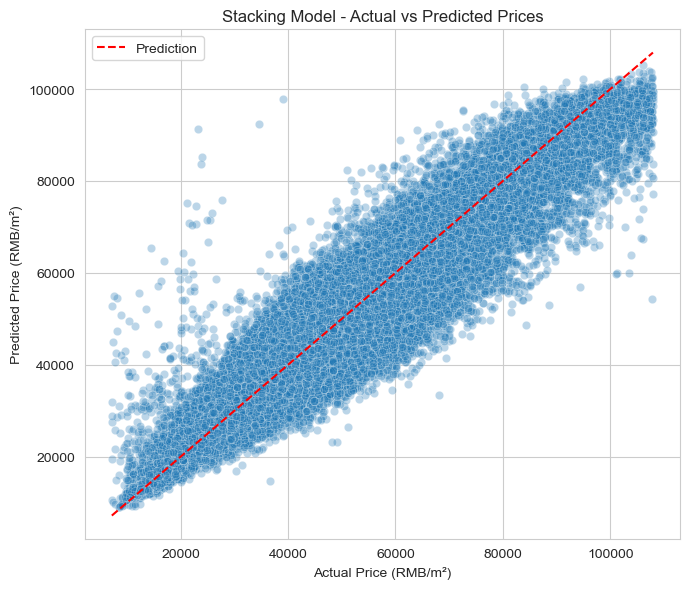

In [3]:
# 预测可视化（原始价格单位）
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test_original, y=y_pred_original, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--', label='Prediction')

plt.xlabel('Actual Price (RMB/m²)')
plt.ylabel('Predicted Price (RMB/m²)')
plt.title('Stacking Model - Actual vs Predicted Prices')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
#拟合训练集性能（R²）
from sklearn.metrics import r2_score

y_train_pred = stacking_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f"Training Set R²: {r2_train:.4f}")

Training Set R²: 0.9505


In [4]:
#交叉验证评分
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(stacking_model, X, y, cv=5, scoring='r2')
print(f"Cross Validation R² Average Value: {cv_scores.mean():.4f}")

KeyboardInterrupt: 

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

# 自定义RMSE评分指标
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse)

# 进行R²交叉验证
r2_cv_scores = cross_val_score(stacking_model, X, y, cv=5, scoring='r2')
# 进行RMSE交叉验证
rmse_cv_scores = cross_val_score(stacking_model, X, y, cv=5, scoring=rmse_scorer)

# 输出交叉验证的R²平均值
print(f"Cross Validation R² Average Value: {r2_cv_scores.mean():.4f}")
# 输出交叉验证的RMSE平均值
print(f"Cross Validation RMSE Average Value: {rmse_cv_scores.mean():.4f}")

Cross Validation R² Average Value: 0.7872
Cross Validation RMSE Average Value: 0.1684


In [ ]:
#Cross Validation R² Average Value: 0.7847

In [ ]:
# R²: 0.9337R²: 0.9337
# Cross Validation R² Average Value: 0.7933

In [ ]:
#训练集0.9489 说明模型能很好拟合训练数据，具有很强的表达能力
#交叉验证从 0.9489 ➝ 0.7191，说明有 轻微过拟合，但下降幅度不算严重。
#这种差距在 stacking 模型中是比较正常的，因为：底层模型学习复杂；同时meta-model 再次拟合，模型容量大，容易学到训练集的细节。